In [108]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader,ConcatDataset
import matplotlib.pyplot as plt
import cv2

In [109]:
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),

])

def target_transform(mask):
    mask = mask.resize((256, 256), Image.NEAREST)  # Resize with nearest neighbor to preserve labels
    mask = np.array(mask)  # Convert to numpy array
    mask = torch.from_numpy(mask).long()  # Convert to torch tensor
    return mask


In [110]:
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [111]:
# Create DataLoader
# Combine training and validation datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])
train_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)


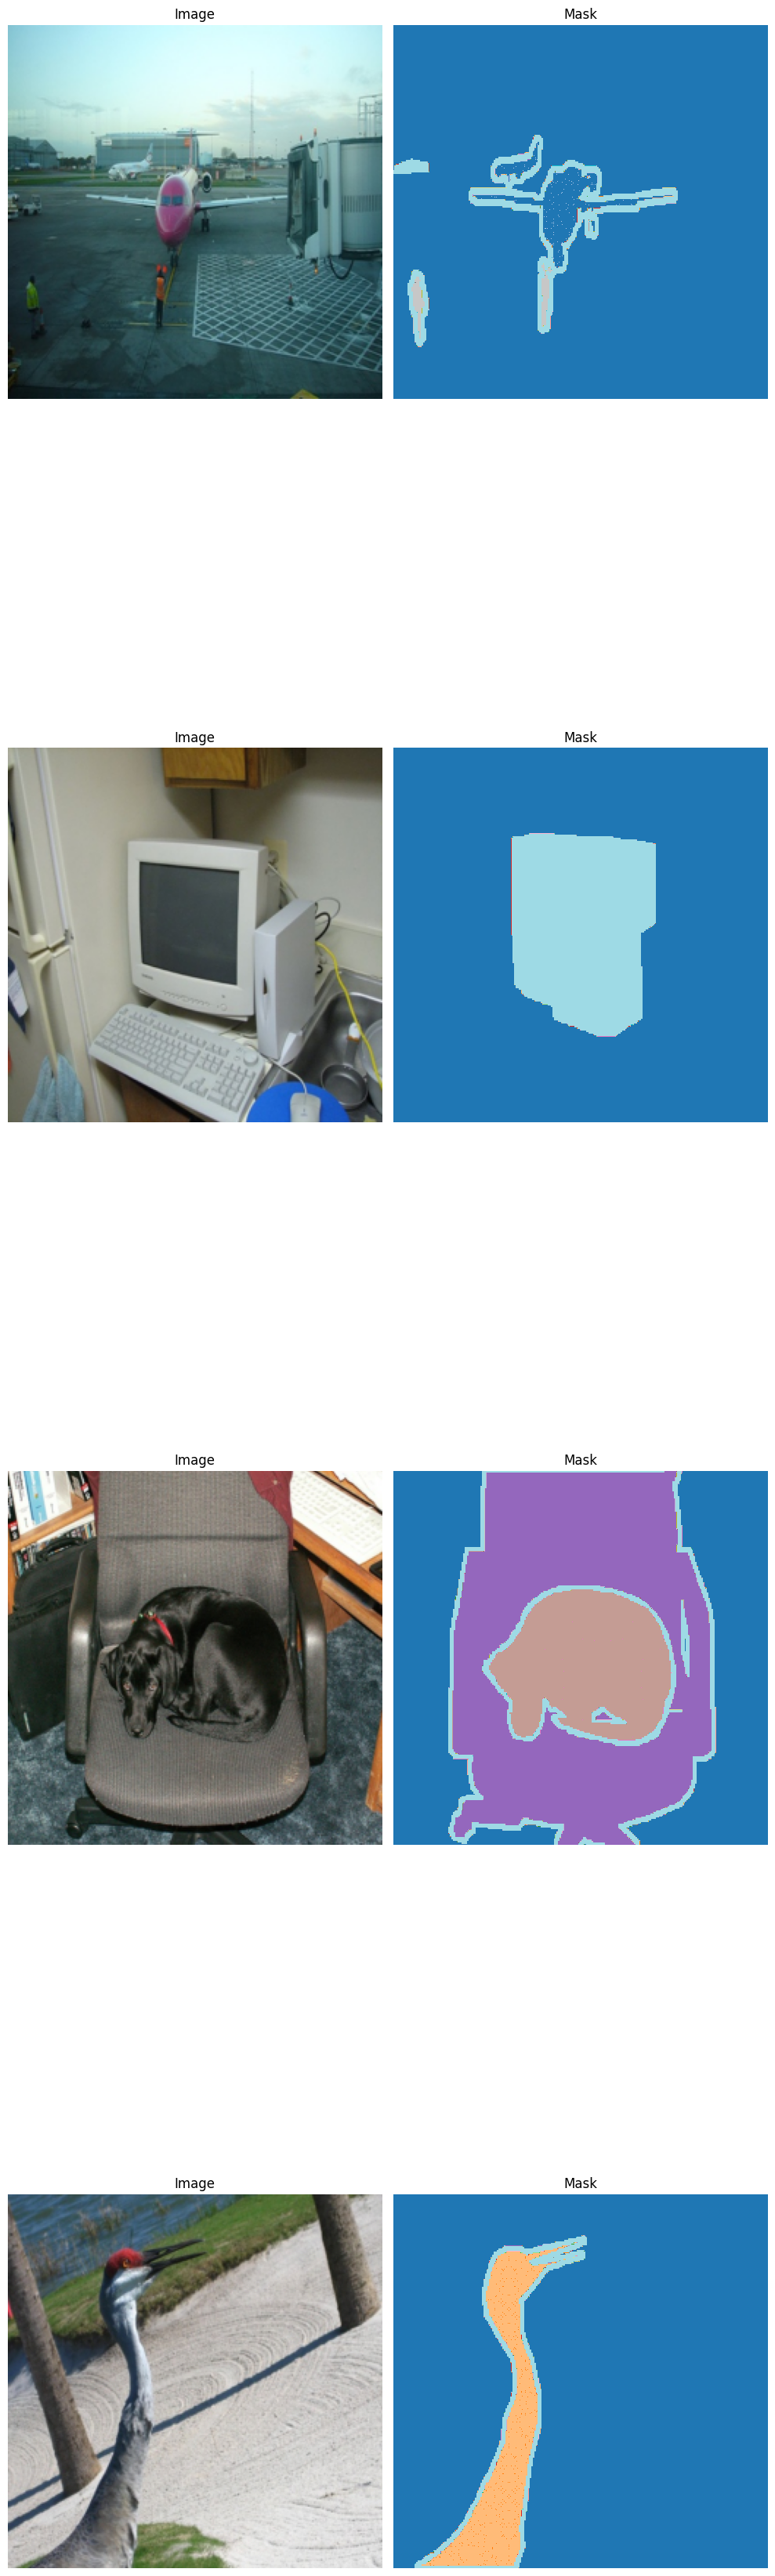

In [112]:

import torchvision.transforms.functional as TF
def visualize_dataset(dataset, num_samples=4):
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 10 * num_samples))

    for i in range(num_samples):
        image, mask = dataset[i]

        # Display image
        axs[i, 0].imshow(TF.to_pil_image(image))  # Convert tensor to PIL Image for display
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')

        # Display mask
        mask_np = mask.numpy()  # Convert tensor to numpy array
        axs[i, 1].imshow(mask_np, cmap='tab20', vmin=0, vmax=20)  # Adjust as per your dataset
        axs[i, 1].set_title('Mask')
        axs[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first few samples in the dataset
visualize_dataset(train_dataset, num_samples=4)

In [113]:
!pip install segmentation_models_pytorch

In [114]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

# Load the pretrained U-Net model with ResNet-34 encoder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21  # Number of classes for Pascal voc
)

In [115]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


In [116]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [117]:
from tqdm import tqdm
progress_bar = tqdm(total=len(train_dataset), desc='Training', leave = True)

Training:   0%|          | 0/1464 [00:00<?, ?it/s]

In [118]:
# Training loop
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:

        torch.set_printoptions(threshold=10000, edgeitems=1000, linewidth=1000)

        inputs, labels = inputs.to(device), labels.to(device).long()


        optimizer.zero_grad()
        outputs = model(inputs)

        labels = labels.squeeze(1)
        labels=labels
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.update(1)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
progress_bar.close()

Training:   6%|▌         | 91/1464 [01:02<13:47,  1.66it/s]

Epoch 1/10, Loss: 1.4311528970365939


Training:  12%|█▎        | 183/1464 [01:59<14:08,  1.51it/s]

Epoch 2/10, Loss: 0.891865396629209


Training:  19%|█▉        | 275/1464 [02:56<11:55,  1.66it/s]

Epoch 3/10, Loss: 0.8629777340785317


Training:  25%|██▌       | 367/1464 [03:52<11:13,  1.63it/s]

Epoch 4/10, Loss: 0.7866741036591323


Training:  31%|███▏      | 459/1464 [04:49<10:30,  1.59it/s]

Epoch 5/10, Loss: 0.7627493570680204


Training:  38%|███▊      | 551/1464 [05:46<09:12,  1.65it/s]

Epoch 6/10, Loss: 0.7503930722241816


Training:  44%|████▍     | 643/1464 [06:42<08:38,  1.58it/s]

Epoch 7/10, Loss: 0.6925635849652083


Training:  50%|█████     | 735/1464 [07:39<07:22,  1.65it/s]

Epoch 8/10, Loss: 0.7817883893199589


Training:  56%|█████▋    | 827/1464 [08:36<06:22,  1.66it/s]

Epoch 9/10, Loss: 0.6893244418113128


Training:  63%|██████▎   | 920/1464 [09:32<05:38,  1.61it/s]

Epoch 10/10, Loss: 0.624776535384033


In [119]:
def decode_segmap(image, colormap):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, len(colormap)):
        idx = image == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [130]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# After uploading, specify the filename and load the image
file_name = "2008_000038.jpg"
test_img_path = file_name

test_img = Image.open(test_img_path).convert("RGB")
test_img = transform(test_img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_img)
output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()



Saving 2008_000038.jpg to 2008_000038 (4).jpg


In [121]:
def create_pascal_voc_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]          # background
    colormap[1] = [128, 0, 0]        # aeroplane
    colormap[2] = [0, 128, 0]        # bicycle
    colormap[3] = [128, 128, 0]      # bird
    colormap[4] = [0, 0, 128]        # boat
    colormap[5] = [128, 0, 128]      # bottle
    colormap[6] = [0, 128, 128]      # bus
    colormap[7] = [128, 128, 128]    # car
    colormap[8] = [64, 0, 0]         # cat
    colormap[9] = [192, 0, 0]        # chair
    colormap[10] = [64, 128, 0]      # cow
    colormap[11] = [192, 128, 0]     # dining table
    colormap[12] = [64, 0, 128]      # dog
    colormap[13] = [192, 0, 128]     # horse
    colormap[14] = [64, 128, 128]    # motorbike
    colormap[15] = [192, 128, 128]   # person
    colormap[16] = [0, 64, 0]        # potted plant
    colormap[17] = [128, 64, 0]      # sheep
    colormap[18] = [0, 192, 0]       # sofa
    colormap[19] = [128, 192, 0]     # train
    colormap[20] = [0, 64, 128]      # tv/monitor
    return colormap


In [131]:
colormap = create_pascal_voc_label_colormap()
segmentation_map = decode_segmap(output, colormap)

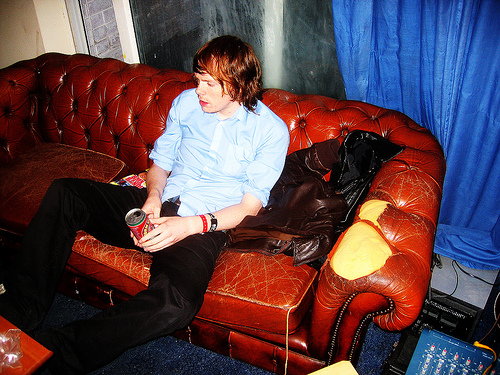

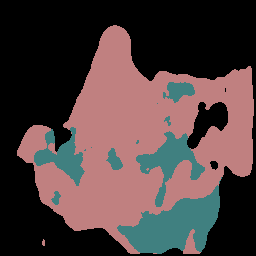

In [132]:
import cv2
from google.colab.patches import cv2_imshow

# Load and display the original image
img = cv2.imread(test_img_path)
cv2_imshow(img)

# Display the segmentation map (assuming 'segmentation_map' is properly defined)
cv2_imshow(cv2.cvtColor(segmentation_map, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


In [124]:
print(len(combined_dataset))

2913


In [125]:
# Save the model weights
model_save_path = 'unet_cityscapes.pth'
torch.save(model.state_dict(), model_save_path)


In [126]:
# Load the model weights
model_load_path = 'unet_cityscapes.pth'
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()  # Set the model to evaluation mode

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track